# Introducció a l'aprenentatge per reforç

**Assignatura** : Sistemes d'aprenentatge automàtic

**Professor** : Ramon Mateo Navarro

**Credits i referències**: [https://towardsdatascience.com/q-learning-for-beginners-2837b777741]()

## Llibreries necessàries

Per aquesta pràctica necessitarem instal·lar **Gym**. **Gym** és un framework que conté entorns de múltiples jocs desenvolupat per OpenAI. És un framework pensat per poder entrenar models de RL. 

L'objectiu principal de **Gym** és oferir una interfície estàndard per a entorns de RL, permetent als investigadors i desenvolupadors entrenar els seus models de manera consistent i comparar els resultats de manera justa. Gym s'ocupa de la part de l'entorn del bucle d'aprenentatge per reforç, deixant que l'usuari es concentri en el disseny i l'implementació de l'algoritme d'aprenentatge.

In [9]:
!pip install pygame
!pip install gym

   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.8 MB 640.0 kB/s eta 0:00:17
   ---------------------------------------- 0.0/10.8 MB 653.6 kB/s eta 0:00:17
    --------------------------------------- 0.3/10.8 MB 2.2 MB/s eta 0:00:05
   --- ------------------------------------ 0.8/10.8 MB 5.2 MB/s eta 0:00:02
   ----- ---------------------------------- 1.5/10.8 MB 7.6 MB/s eta 0:00:02
   -------- ------------------------------- 2.2/10.8 MB 8.8 MB/s eta 0:00:01
   -------- ------------------------------- 2.2/10.8 MB 8.8 MB/s eta 0:00:01
   -------- ------------------------------- 2.2/10.8 MB 8.8 MB/s eta 0:00:01
   -------- ------------------------------- 2.2/10.8 MB 8.8 MB/s eta 0:00:01
   -------- ------------------------------- 2.2/10.8 MB 5.1 MB/s eta 0:00:02
   -------- ------------------------------- 2.3/10.8 MB 4.6 MB/s eta 0:00:02
   -------- ------------------------------- 2.3/10.8 MB 4.3 MB/s eta 0:00:02
  

## Imports

In [1]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output


En aquesta primera pràctica farem servir l'entorn frozen lake. Frozen lake és un joc en el que l'agent ha d'arribar a un destí sense caure pels forats.

![](images_w5\1_frozen_lake.gif)
![](images_w5\2_frozen_lake.gif)

El nostre objectiu serà programar i fer que l'agent aprengui a arribar a meta sense caure en el forat. 

El primer que farem serà crear l'entorn de joc. Gym disposa de múltiples jocs pel que el primer que haurem de fer es indicar quín volem. 

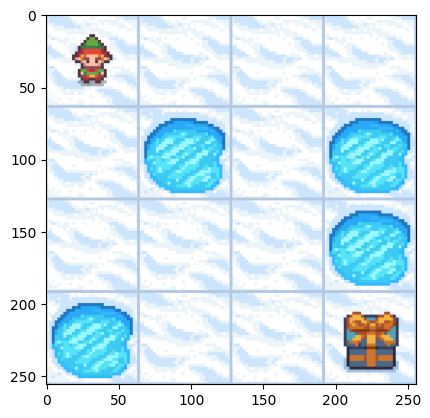

In [21]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")
env.reset(seed=32)
result = env.render()
plt.imshow(result)


Hem observat ara com és el joc. Observarem ara com es pot obtenir l'espai d'accions possibles. Observarem com el nostre entorn pot executar fins a quatre accions diferents. Després també podem veure els possibles estats que pot tenir el joc, en aquest cas setze.

In [8]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(16)


## Creant la Q-table

Ho tenim tot ja, accions i possibles estats. Per tant nem a crear ara la nostre Q-table

In [16]:
nb_states = env.observation_space.n  # = 16
nb_actions = env.action_space.n      # = 4
qtable = np.zeros((nb_states, nb_actions))

# Let's see how it looks
print('Q-table')
print(qtable)



Q-table
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Acabem d'inicialitzar la nostra Q-table amb tots els valors ara a zero.

Repasem els comandaments: 

    - 0: LEFT
    - 1: DOWN
    - 2: RIGHT
    - 3: UP

Aquests valors han sigut obtinguts del propi codi: [Frozen Lake](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py#L10) 

Anem a veure ara això com funciona:

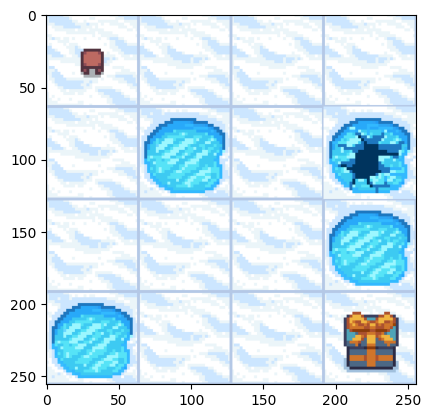

In [31]:
env.step(2)
result = env.render()
plt.imshow(result)

Podem observar com el nostre amic s'ha mogut cap a la dreta.

Ara anem a fer les coses bé. environment.step() retorna fins a quatre valors. Aquests són:
* new_state: el nou estat del joc
* reward: la recompensa per efectuar aquell moviment o pas
* done: si el joc ha finalitzat o no
* info: informació extra que en aquest cas no serà necessària.

Anem ara a programar i entrenar el model. 

In [32]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 17})

# inicialitzem la q-table
qtable = np.zeros((env.observation_space.n, env.action_space.n))



print('Q-table before training:')
print(qtable)

Q-table before training:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Entrenant el model. Afegim que pugui renderitzar el joc. Aquests es visualitzarà cada 50 episodis per veure la seva evolució. 

In [35]:
# Hiperparàmetres
episodes = 1000        # Número total d'episodis, seria com els epochs
alpha = 0.8            # Learning rate
gamma = 0.95           # Discount factor

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

# Llista de resultats 
outcomes = []
rewards = []
# renderització
render = False
episodes_render = 50

qtable = np.zeros((env.observation_space.n, env.action_space.n))
outcomes = []
for episode in range(episodes):
    state = env.reset()
    done = False
    total_rewards = 0
    outcomes.append("Failure")
    while not done:
          exp_exp_tradeoff = random.uniform(0, 1)

          if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])

          else:
            action = env.action_space.sample()
          
          new_state, reward, done = env.step(action)

          # actualitzem Q(s,a)
          qtable[state, action] = qtable[state, action] + alpha * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])

          total_rewards += reward

          # actualitzem l'estat del joc
          state = new_state
          if render and episodes % episodes_render == 0 :
            result = env.render()
            plt.figure(figsize=(2,2))
            plt.imshow(result[0])
            plt.axis('off')  # Ocultar ejes
            display(plt.gcf())  # Mostrar figura actual
            clear_output(wait=True)  # Limpiar la salida antes de la próxima visualización
            
            time.sleep(0.5)  # Esperar 0

          # If we have a reward, it means that our outcome is a success
          if reward:
            outcomes[-1] = "Success"
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)

ValueError: too many values to unpack (expected 3)

## Veient els resultats

In [ ]:
env.reset()
max_steps = 100
for episode in range(5):
    state = env.reset()
    step = 0
    done = False
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(max_steps):
        
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(qtable[state,:])
        
        new_state, reward, done, info = env.step(action)
        result = env.render()
        plt.figure(figsize=(2,2))
        plt.imshow(result[0])
        plt.axis('off')  # 
        display(plt.gcf())  
        clear_output(wait=True)  # 
        time.sleep(0.5)  # Esperar 0
        
        if done:
            # Total de episodis necessaris.
            print("Number of steps", step)
            break
        state = new_state
env.close()